In [112]:
# packages
import numpy as np  # matrix and vector operations
import matplotlib.pyplot as plt  # visualization
import fssa as fssa  # scaling collapse 
from utils import *  # all things ID of MBL
from time import time
import glob
import numpy.ma as ma
from plotting import *
import scipy as sp
import seaborn as sns
from tqdm import tqdm

import matplotlib as mpl
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

In [113]:
## Global variables
# List of available system sizes
Ls = [8, 10, 12, 14, 16]
# List of available disorder strengths
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

# Download data
# TODO (curl from ERDA)

## Eigenvector dominance

In [122]:
from utils import *

result = {}
tmp_ws = np.logspace(0,2,100)
for L in [8,10,12,14]:
    result[L] = []
    for seed in range(5):
        max_amplitude = []
        for W in tqdm(tmp_ws):
            H = constructHamiltonian(L = L, W = W, U = 1.0, t = 1.0, seed=seed)
            _, eigvecs = np.linalg.eigh(H)    
            max_amplitude.append(np.mean(np.sum(np.abs(eigvecs), axis=0)))
        result[L].append(max_amplitude)
        
#np.save("eigenvector_components.npy", result)

100%|██████████| 100/100 [04:43<00:00,  2.84s/it]


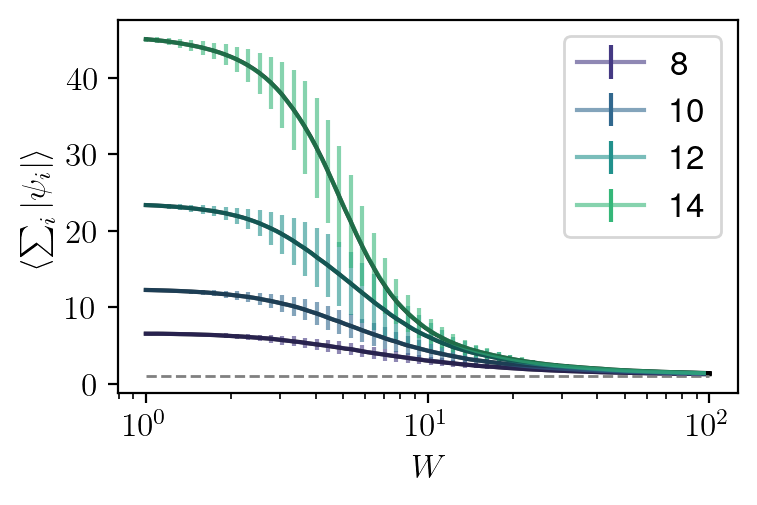

In [150]:
fig, ax = plt.subplots(figsize=fig_size)

result = np.atleast_2d(np.load("eigenvector_components.npy", allow_pickle=True))[0][0]

colors = sns.color_palette("viridis", len(Ls))
for c,L in zip(colors,[8,10,12,14]):
    ax.errorbar(tmp_ws[::2], np.mean(result[L], axis=0)[::2], yerr=np.std(result[L], axis=0)[::2], alpha=0.6, c=c, label=L)
    ax.plot(tmp_ws, np.mean(result[L], axis=0), c='k')
    
ax.plot([1,1e2], [1,1], '--', c='gray', linewidth=1)
#ax.set_yticks([1,10,20,30,40])
ax.set_xscale('log')
ax.set_xlabel('$W$')
ax.set_ylabel('$ \\langle \sum_i | \psi_i | \\rangle$')
legend = ax.legend(fancybox=True)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    
fig.savefig("EigenvectorComponents.pdf", bbox_inches='tight')

## Averages

In [5]:
# Gather data
files = {}
for L in Ls:
    files[L] = []
    files[L] = glob.glob("cluster_data/2nn_L_{0}/*".format(L))
    print("For L = {0}, {1} seeds are available".format(L, len(files[L])))

For L = 8, 101000 seeds are available
For L = 10, 10100 seeds are available
For L = 12, 5010 seeds are available
For L = 14, 1001 seeds are available
For L = 16, 500 seeds are available


In [6]:
def load_IDs(L, Ws, seeds):
    ID = -1*np.ones((len(seeds),len(Ws)))
    rsquared = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("cluster_data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            rsquared[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    rsquared = ma.masked_equal(rsquared, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    
    if missing:
        print("Missing seed nrs: ")
        print(missing)
        
    return ID, rsquared

In [7]:
IDs = {}
rsquareds = {}

In [8]:
for L in Ls:
    print("Loading data for L = {0}...".format(L))
    IDs[L], rsquareds[L] = load_IDs(L, Ws, range(0, len(files[L])))
    print("Done!")

Loading data for L = 8...
Loaded 101000 out of 101000 seeds
Done!
Loading data for L = 10...
Loaded 10100 out of 10100 seeds
Done!
Loading data for L = 12...
Loaded 5010 out of 5010 seeds
Done!
Loading data for L = 14...
Loaded 1001 out of 1001 seeds
Done!
Loading data for L = 16...
Loaded 500 out of 500 seeds
Done!


## Nearest Neighbor distance distribution functions

In [14]:


bins_upper = dict({8:10,10:20,12:35,14:70,16:160})

def normal(x, a,sigma, mu):
    return a/(sigma*(2*np.pi)**0.5) * np.exp(-.5*((x-mu)/sigma)**2)

hists = {}
mu = {}
sigma = {}
bins = {}
for L in Ls:
    hists[L] = {}
    mu[L] = {}
    sigma[L] = {}
    
    bins[L] = np.linspace(0,bins_upper[L],50)
    
    for i,W in tqdm(enumerate(Ws)):
        histogram = 0
        for seed in range(100):
            data = np.atleast_2d(np.load("cluster_data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            h, binedges = np.histogram(data[i]['nndist'], bins=bins[L], density=True)
            histogram += h
        hists[L][W] = histogram

        y = histogram
        x = bins[L][:-1]
        popt, pcov = sp.optimize.curve_fit(normal, x,y, maxfev=10000, p0=[5000,4,15])
        mu[L][W] = popt[2]
        sigma[L][W] = popt[1]

55it [00:03, 17.42it/s]
55it [00:03, 15.07it/s]
55it [00:05, 10.87it/s]
55it [00:07,  7.54it/s]
55it [00:32,  1.70it/s]


[3.3499999999999974, 4.399999999999993, 3.8999999999999955, 3.9499999999999953, 3.999999999999995]


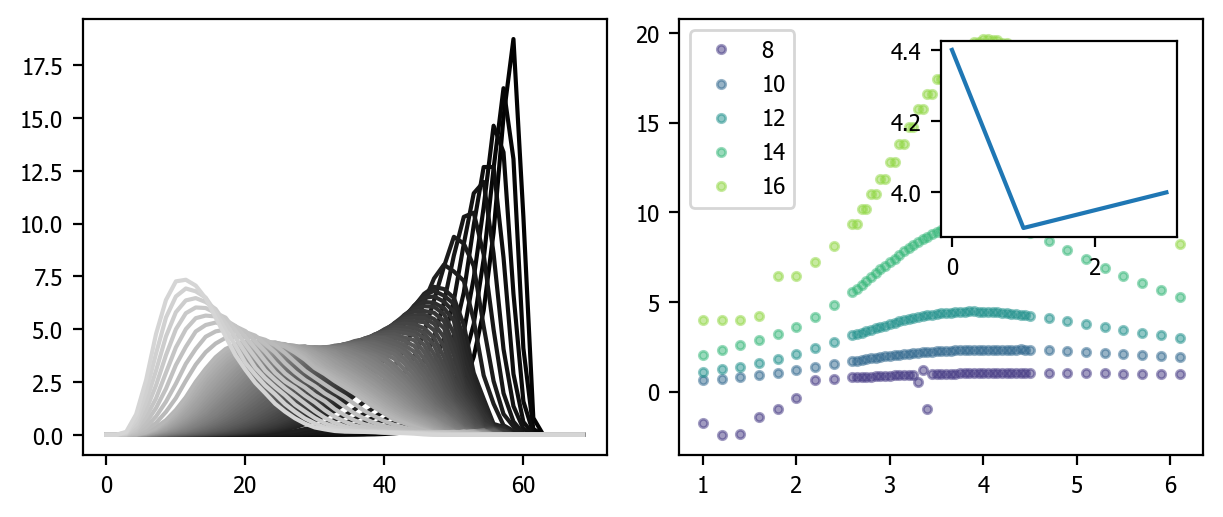

In [15]:
fig, ax = plt.subplots(1,2, figsize=(6, 4/golden_ratio), constrained_layout=True)

colors = sns.color_palette("gray", 10+len(Ws))
for c, W in zip(colors, Ws):
    ax[0].plot(bins[14][:-1], hists[14][W], c=c)

colors = sns.color_palette("viridis", len(Ls))
sigma_peaks = []
for c,L in zip(colors,Ls):
    ax[1].plot(sigma[L].keys(),sigma[L].values(), 'o', label=L, markersize=3, alpha=.5, c=c)
    sigma_peaks.append(np.array(list(sigma[L].keys()))[np.argmax(np.array(list(sigma[L].values())))])
ax[1].legend(fancybox=True)

axin = ax[1].inset_axes([0.5, 0.5, 0.45, 0.45])
print(sigma_peaks)
axin.plot(sigma_peaks[1:])

## 2NN and scaling collapse
2NN is a neighbour graph algo. which determines the intrinsic dimension of a dataset -- when applied to a list of eigenvectors corresponding to one realization of a single disorder strength.

NameError: name 'ret' is not defined

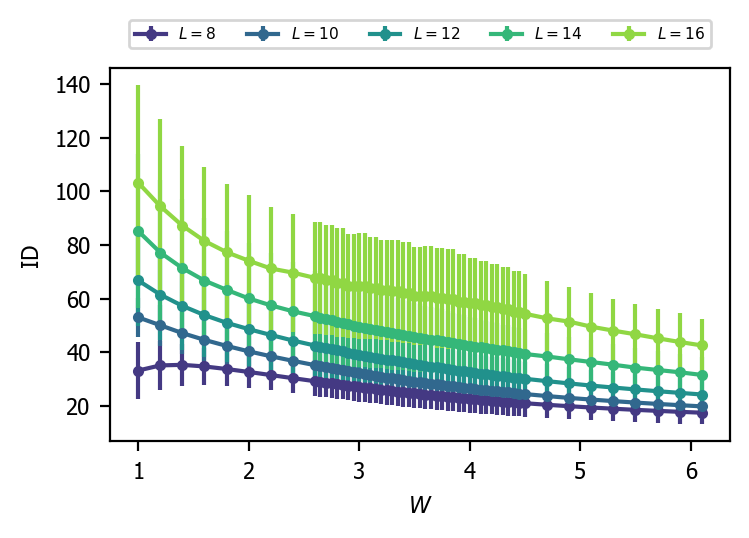

In [11]:
averaged_ID = {}
for L in Ls:
    averaged_ID[L] = ma.sum(IDs[L]*rsquareds[L],axis=0)/ma.sum(rsquareds[L],axis=0)

fig, ax = plt.subplots()

colors = sns.color_palette("viridis", len(Ls))
for c,L in zip(colors,Ls):
    ax.errorbar(Ws, averaged_ID[L], yerr=ma.std(IDs[L]*rsquareds[L],axis=0), marker='o', ms=3, c=c, label="$L={}$".format(L))

ax.set_xlabel("$W$")
ax.set_ylabel("ID")
ax.legend(fancybox=True, loc='upper center', fontsize='x-small', ncol=5, bbox_to_anchor=(0.5, 1.15))

scale_Ls = [10,12,14,16]
scale_Ws = [2.8,4.2]
W_start = np.argwhere(Ws>=scale_Ws[0])[0][0]
W_end = np.argwhere(Ws>=scale_Ws[1])[0][0]

scale_Ws = Ws[W_start:W_end]

a = np.array([averaged_ID[L][W_start:W_end] for L in scale_Ls])
auto_scaled_data = fssa.scaledata(scale_Ls, scale_Ws, a, a*0.1, ret.rho, ret.nu, ret.zeta)
ret = fssa.autoscale(scale_Ls, scale_Ws, a, a*0.1, 3.8, -0.5, -0.5)

axin = ax.inset_axes([0.5, 0.5, 0.45, 0.45])
for i,L in enumerate(scale_Ls):
    axin.plot(auto_scaled_data.x[i], auto_scaled_data.y[i], '.', markersize=1, c=colors[i+1])

## Plateauing

In [ ]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], './cluster_scripts'))
from utils_cluster import nn2

def plateau(L, seed):
    # Fixed high disorder to confirm ID ~> L
    W = 20

    H = constructHamiltonian(L = L, W = W, seed=seed)
    _, eigvecs = np.linalg.eigh(H)

    ID_vs_fraction = {}
    num_averages = 5
    for fraction in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        ID_vs_fraction[fraction] = []
        for a in range(num_averages):
            # Take 'fraction' many eigenstates, random and uniformly
            sample = np.random.choice(range(len(eigvecs)), int(fraction*len(eigvecs)))
            sample = eigvecs[:,sample]
            
            # Compute ID for this sample
            ID, rsquared, nndist = nn2(sample)
            ID_vs_fraction[fraction].append([ID,rsquared])
    
    return ID_vs_fraction

In [ ]:
data = plateau(10, 1)

In [ ]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
means = []
for fraction in fractions:
    m = np.mean(data[fraction], axis=0)
    means.append(m)

plt.plot(fractions, means)

## Playground

In [177]:
result = np.atleast_2d(np.load("eigenvector_components.npy", allow_pickle=True))[0][0]

tmp_ls = [8,10,12,14]
a = np.array([np.mean(result[L],axis=0)[20:50] for L in tmp_ls])
da = a * 0.1
ret = fssa.autoscale(tmp_ls, tmp_ws[20:50], a, da, 3.6, 0.5, 0.5)
ret

           dnu: 0.08805463702867196
          drho: 0.8013896968827708
         dzeta: 0.2717155783142253
        errors: array([0.8013897 , 0.08805464, 0.27171558])
 final_simplex: (array([[8.11404307, 0.48786909, 0.89967906],
       [8.1232518 , 0.48690879, 0.89501074],
       [8.12080147, 0.48816529, 0.89784605],
       [8.11760893, 0.48680493, 0.89527967]]), array([0.13418992, 0.13422883, 0.13441676, 0.13447647]))
           fun: 0.13418991514050538
       message: 'Optimization terminated successfully.'
          nfev: 113
           nit: 61
            nu: 0.48786909037425785
           rho: 8.114043074704345
        status: 0
       success: True
         varco: array([[ 0.64222545, -0.02239128, -0.16362998],
       [-0.02239128,  0.00775362,  0.01958708],
       [-0.16362998,  0.01958708,  0.07382936]])
             x: array([8.11404307, 0.48786909, 0.89967906])
          zeta: 0.8996790627009976

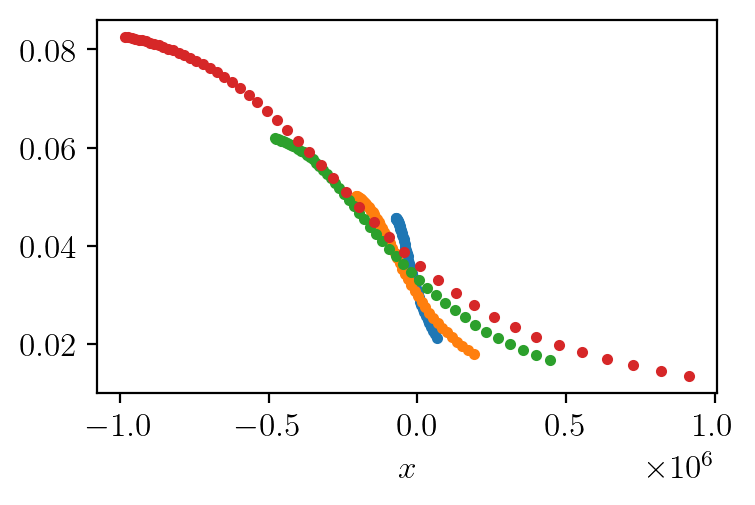

In [176]:
auto_scaled_data = fssa.scaledata(tmp_ls, tmp_ws[:50], a, da, ret.rho, ret.nu, ret.zeta)
fig, ax = plt.subplots()
ax.plot(
    auto_scaled_data.x.T, auto_scaled_data.y.T,
    '.',
)
#ax.set_xbound(-4, 2)
ax.set_xlabel(r'$x$')
plt.show()